In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

For explanation of the the individual columns in the result csv file, expand the next cell

In [2]:
"""" Results' columns' description 
'neuron':  neuron name extracted from file name
'subtype': neuron name extracted from file name
'entry_point': entry point of the neuron, read from seperate txt file

'volume': volume of the masked 3D image in um3
'3D_convex_volume': volume of the convex-hull for the 3D image in um3
'net_area': area of the object in the 2D image (the 2D is a max projection of the 3D image) in um2
'area': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops) in um2 

'density_2D': solidity value obtained from skimage.measure.regionprops on the 2D image
'density_3D': pixel count of 3D image/pixel count of 3D convexhull 
'object_perimeter': object perimenter value obtained from skimage.measure.regionprops on the 2D image
'convex_perimeter': perimeter of the surronding convex_hull

'AP_spread': (max-min) of value pixels index in last (x) dimension of the 2D image in um
'DV_spread': (max-min) of value pixels index in (y) dimension of the 2D image in um                
'ellipticity': (elipse_major - elipse_minor)/ elipse_major
'PCA_elongation': (max_eign_value - min_eign_value)/ max_eign_value
'eccentricity': eccentricity value obtained from skimage.measure.regionprops on the 2D image 
'circularity': (4*np.pi*convex_area)/(convex_perimeter**2)


'compactness': object_perimeter**2/(4*np.pi*net_area)
'surface_area': mesh_surface_area of the marching_cubes on the 3D masked image in um2
'3D_convex_surface': mesh_surface_area of the marching_cubes on the 3D masked image in um2



'convexity_2D': convex_perimeter/object_perimeter
'convexity_3D': 3D_convex_surface/surface_area
'orientation': orientation value obtained from skimage.measure.regionprops on the 2D image 
'feret_diameter_max': feret_diameter_max value obtained from skimage.measure.regionprops on the 2D image 

'centroidZ': Z position of the centroid from regionprops on the 3D masked image 
'centroidY': Y position of the centroid from regionprops on the 3D masked image 
'centroidX': X position of the centroid from regionprops on the 3D masked image 
'cen_EP_dis': ecludian distance of the centroid from the entry point
'cen_EP_angle': angle of the line between centroid from the entry point (np.arctan2)
'cen_EP_y', 'cen_EP_x': the x,y position of the centroid with the entry point as center (0,0) 

£££ PCA analysis
'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry': different attempts for asymmetry calculation (all bad)

'xP_weight', 'xP_scale','xP_angle','xP_xy':
'xN_weight','xN_scale','xN_angle','xN_xy',
'yP_weight','yP_scale','yP_angle','yP_xy',
'yN_weight','yN_scale','yN_angle','yN_xy',
'PCA_angle':
'PCA_xy':
'PCA_shift_centroid_y', 'PCA_shift_centroid_x': position of the 2D_image centroid after shifting according to PCA

'DGI': from the old script 
"""

#The pixel resolution has to be provided to calculate everything in um(n) 

'" Results\' columns\' description \n\'neuron\':  neuron name extracted from file name\n\'subtype\': neuron name extracted from file name\n\'entry_point\': entry point of the neuron, read from seperate txt file\n\n\'volume\': volume of the masked 3D image in um3\n\'3D_convex_volume\': volume of the convex-hull for the 3D image in um3\n\'net_area\': area of the object in the 2D image (the 2D is a max projection of the 3D image) in um2\n\'area\': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops) in um2 \n\n\'density_2D\': solidity value obtained from skimage.measure.regionprops on the 2D image\n\'density_3D\': pixel count of 3D image/pixel count of 3D convexhull \n\'object_perimeter\': object perimenter value obtained from skimage.measure.regionprops on the 2D image\n\'convex_perimeter\': perimeter of the surronding convex_hull\n\n\'AP_spread\': (max-min) of value pixels index in last (x) dimension of the 2D image in um\n\'DV_spread\': (max-min) 

In [3]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

In [4]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/controls/adult_1/'
save_path = '/home/tli_project/Desktop/Data/controls/adult_1/output/'
px_resolution = (0.4, 0.076, 0.076) #z,y,x resolution
save_name = 'adult_T4_results_Nov_2022_2.csv'

In [5]:
# getting list of image file names in data_path
N_folders = [name for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '.tif' in f]
N_folders = sorted(N_folders)
N_folders[:5]

['T4-02_A.tif', 'T4-03_D.tif', 'T4-04_B.tif', 'T4-05_D.tif', 'T4-06_D.tif']

In [6]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/home/tli_project/Desktop/Data/controls/adult_1/Adults_ctrl_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [7]:
results_cols = ['neuron','subtype', 'entry_point',
                'volume','3D_convex_volume', 'net_area', 'area',
                'AP_spread', 'DV_spread', 'eccentricity', 'ellipticity','PCA_elongation', 'circularity',
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'compactness', 'surface_area', '3D_convex_surface',
                'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max', 'neu_asymmetry',
                # 'DV_asymmetry', 'AP_asymmetry',
                # 'DV_cent_dens_asym', 'AP_cent_dens_asym', 'DV_EP_dens_asym', 'AP_EP_dens_asym',
                'centroidZ','centroidY', 'centroidX', 'px_variance', 'px_std',
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_y', 'cen_EP_x',
                'cen_EP_norm_y', 'cen_EP_norm_x',
                'PC1_angle2', 'PC1_cen_x', 'PC1_cen_y', 'PC1_ori_cen_x', 'PC1_ori_cen_y',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PC1_angle','PC1_x','PC1_y','PC1_shift_centroid_y', 'PC1_shift_centroid_x', 'DGI', 'DGI_angle']
results_df = pd.DataFrame(columns=results_cols)
for i, neu_file in enumerate(N_folders):
    results_df.loc[neu_file] = [None for col in results_df.columns]

In [8]:
results_df.head()

,neuron,subtype,entry_point,volume,3D_convex_volume,net_area,area,AP_spread,DV_spread,eccentricity,...,yN_scale,yN_angle,yN_xy,PC1_angle,PC1_x,PC1_y,PC1_shift_centroid_y,PC1_shift_centroid_x,DGI,DGI_angle
T4-02_A.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-03_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-04_B.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-05_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-06_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
def get_theta_angle(img_2D, entry_point):
    theta = regionprops(img_2D)[0].orientation
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
    inv_rot_mat = np.linalg.inv(rotation_mat)


    coords = (np.argwhere(img_2D) - entry_point).T
    coords = np.vstack((coords[1],coords[0]))
    # rotate the original coordinates
    rotated_coords = rotation_mat * coords

    x_transformed, y_transformed = rotated_coords.A
    x_pos = x_transformed[x_transformed>=0]
    x_neg = x_transformed[x_transformed<0]
    y_pos = y_transformed[y_transformed>=0]
    y_neg = y_transformed[y_transformed<0]

    PCAs = {'x_pos':x_pos, 'x_neg':x_neg, 'y_pos':y_pos, 'y_neg':y_neg}
    PCs_fractions = {key:len(x) for key,x in PCAs.items()}
    
    PC1 = {max(PCs_fractions, key=PCs_fractions.get): PCAs[max(PCs_fractions, key=PCs_fractions.get)]}

    angular_rotation = {'x_pos':0, 'x_neg':180, 'y_pos':90, 'y_neg':270}
    element = next(iter(PC1))
    PC1_angle = np.rad2deg(theta) + angular_rotation[element]
    PC1_angle = np.deg2rad(PC1_angle)

    element = next(iter(PC1))
    if 'x_pos' in element:
        PC1_xys = rotated_coords[:,x_transformed>=0]
        PC1_ori_xys = coords[:,x_transformed>=0]
    elif 'x_neg' in element:
        PC1_xys = rotated_coords[:,x_transformed<0]
        PC1_ori_xys = coords[:,x_transformed<0]
    elif 'y_pos' in element:
        PC1_xys = rotated_coords[:,y_transformed>=0]
        PC1_ori_xys = coords[:,y_transformed>=0]
    elif 'y_neg' in element:
        PC1_xys = rotated_coords[:,y_transformed<0]
        PC1_ori_xys = coords[:,y_transformed<0]
    PC1_cen = PC1_xys.mean(axis=1)
    PC1_ori_cen = PC1_ori_xys.mean(axis=1)

    return PC1_angle, PC1_cen, PC1_ori_cen

In [10]:
px_resolution = np.array(px_resolution)
def process_image(neu_file,results_df):
    neu_res = {}
    # getting entry point
    try:
        neu_res['subtype'] = neu_file[-5]
    except:
        neu_res['subtype'] = 'N'
    # neu_res['neuron'] = neu_file.rstrip('.tif')
    neu_res['neuron'] = neu_file[:-6]
    entry_point = np.array(entry_points[neu_res['neuron']])
    # reading image and make sure it's binary
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    neu_res['entry_point'] = entry_point

    neu_res['volume'] = image.sum()*px_resolution.prod()
    img_2D = image.max(axis=0)
    img_2D[img_2D!=0] = 1
    neu_res['net_area'] = img_2D.sum()*px_resolution[1:].prod()
    reg_prop_2D = regionprops(img_2D)[0]
    neu_res['density_2D'] = reg_prop_2D.solidity
    neu_res['area'] = reg_prop_2D.area_convex*px_resolution[1:].prod()
    neu_res['orientation'] = reg_prop_2D.orientation
    neu_res['eccentricity'] = reg_prop_2D.eccentricity
    neu_res['ellipticity'] = (reg_prop_2D.axis_major_length - reg_prop_2D.axis_minor_length)/reg_prop_2D.axis_major_length
    
    neu_res['feret_diameter_max'] = reg_prop_2D.feret_diameter_max*px_resolution[-1]
    neu_res['convex_perimeter'] = perimeter(reg_prop_2D.image_convex)*px_resolution[-1]
    neu_res['object_perimeter'] = reg_prop_2D.perimeter*px_resolution[-1]
    neu_res['convexity_2D'] = neu_res['convex_perimeter']/neu_res['object_perimeter']
    neu_res['circularity'] = (4*np.pi*neu_res['area'])/(neu_res['convex_perimeter']**2)
    neu_res['compactness'] = (4*np.pi*neu_res['net_area']) / neu_res['object_perimeter']**2

    reg_prop_3D = regionprops(image)[0]
    convex_img_3D = reg_prop_3D.image_convex*px_resolution.prod()
    neu_res['3D_convex_volume'] = reg_prop_3D.area_convex*px_resolution.prod()
    neu_res['density_3D'] = neu_res['volume']/neu_res['3D_convex_volume']
    
    centroid = np.array(reg_prop_3D.centroid)
    neu_res['centroidZ'],neu_res['centroidY'], neu_res['centroidX'], = centroid[0],centroid[1],centroid[2]
    p1 = centroid[1:] - entry_point[1:]
    p1[0] = -1*p1[0]

    neu_res['cen_EP_dis'] = np.linalg.norm(p1)*px_resolution[-1]
    neu_res['cen_EP_y'], neu_res['cen_EP_x'] = p1[0], p1[1]
    neu_res['cen_EP_angle'] = np.rad2deg(np.arctan2(*p1) % (2 * np.pi))

    p1[1] = 6*p1[1]/4
    neu_res['cen_EP_norm_y'], neu_res['cen_EP_norm_x'] = p1[0], p1[1]
    
    # img_PC = reg_prop_3D.coords
    img_PC = np.argwhere(image)
    neu_res['DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*px_resolution[-1]
    neu_res['AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*px_resolution[-1]
    verts, faces, normals, values = marching_cubes(image, step_size=2, spacing=px_resolution)
    neu_res['surface_area'] = mesh_surface_area(verts, faces)
    verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=px_resolution)
    neu_res['3D_convex_surface'] = mesh_surface_area(verts, faces)
    neu_res['convexity_3D'] = neu_res['3D_convex_surface']/neu_res['surface_area']

    #calculating assymetry based on entry point
    img_PC_shifted = img_PC - entry_point

    if neu_res['subtype'] == 'A':
        neu_asymmetry = (len(img_PC_shifted[img_PC_shifted[:,-1]>=0]) - len(img_PC_shifted[img_PC_shifted[:,-1]<0]))/len(img_PC_shifted[img_PC_shifted[:,-1]>=0])
    if neu_res['subtype'] == 'B':
        neu_asymmetry = (len(img_PC_shifted[img_PC_shifted[:,-1]<=0]) - len(img_PC_shifted[img_PC_shifted[:,-1]>0]))/len(img_PC_shifted[img_PC_shifted[:,-1]<=0])
    if neu_res['subtype'] == 'C':
        neu_asymmetry = (len(img_PC_shifted[img_PC_shifted[:,1]>=0]) - len(img_PC_shifted[img_PC_shifted[:,1]<0]))/len(img_PC_shifted[img_PC_shifted[:,1]>=0])
    if neu_res['subtype'] == 'D':
        neu_asymmetry = (len(img_PC_shifted[img_PC_shifted[:,1]<=0]) - len(img_PC_shifted[img_PC_shifted[:,1]>0]))/len(img_PC_shifted[img_PC_shifted[:,1]<=0])
    neu_res['neu_asymmetry'] = neu_asymmetry

    DV_pos = img_PC_shifted[:,-2].max()
    DV_neg = abs(img_PC_shifted[:,-2].min())
    AP_pos = img_PC_shifted[:,-1].max()
    AP_neg = abs(img_PC_shifted[:,-1].min())
    neu_res['DV_asymmetry'] = (max(DV_pos,DV_neg)-min(DV_pos,DV_neg))/max(DV_pos,DV_neg)
    neu_res['AP_asymmetry'] = (max(AP_pos,AP_neg)-min(AP_pos,AP_neg))/max(AP_pos,AP_neg)
    neu_res['px_variance'] = np.var(np.linalg.norm(img_PC_shifted, axis=0))/np.mean(np.linalg.norm(img_PC_shifted, axis=0))
    neu_res['px_std'] = np.std(img_PC_shifted)
    
    neu_res['PC1_angle2'], PC1_center, PC1_ori_cen = get_theta_angle(img_2D,entry_point[1:])
    neu_res['PC1_cen_x'], neu_res['PC1_cen_y'] = PC1_center[0][0], PC1_center[1][0]
    neu_res['PC1_ori_cen_x'], neu_res['PC1_ori_cen_y'] = PC1_ori_cen
    
    # asymmetry_values, PCA_df, shifted_coor, evals, neu_res['PCA_cen_angle'] = analysis.metric_dump(img_2D,entry_point[1:],plot=False)
    asymmetry_values, PCA_df, shifted_coor, evals = analysis.metric_dump(img_2D,entry_point[1:],plot=False)
    neu_res['PCA_elongation'] = abs(evals[0]-evals[1])/evals.max()
    # neu_res['PCA_elongation2'] = 
    asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
    for i,key in enumerate(asymmetries):
        neu_res[key] = asymmetry_values[i]

    PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy']
    PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
    result1 = {PCA_res[i]:val for i,val in enumerate(PCA_arr.ravel())}
    neu_res = neu_res | result1
    neu_res['PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle*-1
    # results_df.PC1_angle[results_df.PC1_angle>315] -= 360
    neu_res['PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
    neu_res['PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]
    PC1_shift_centroid = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
    neu_res['PC1_shift_centroid_y'], neu_res['PC1_shift_centroid_x'] = PC1_shift_centroid[0], PC1_shift_centroid[1]

    neu_res['DGI'], neu_res['DGI_angle'] = analysis.DGI_3D(image,entry_point)

    # add the results as a new line to results_df
    neu_res = [neu_res[val] for val in results_cols]
    results_df.loc[neu_file] = neu_res


# iterating over files in data_path and performing the analysis
for i, neu_file in tqdm(enumerate(N_folders)):
    process_image(neu_file,results_df)

0it [00:00, ?it/s]/home/tli_project/miniconda3/envs/plotting/lib/python3.9/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
28it [01:51,  3.97s/it]


In [11]:
results_df.index = range(len(N_folders))

In [12]:
results_df.head()

,neuron,subtype,entry_point,volume,3D_convex_volume,net_area,area,AP_spread,DV_spread,eccentricity,...,yN_scale,yN_angle,yN_xy,PC1_angle,PC1_x,PC1_y,PC1_shift_centroid_y,PC1_shift_centroid_x,DGI,DGI_angle
0,T4-02,A,"[11, 347, 337]",251.48473,691.67831,86.52448,161.520064,11.096,20.292,0.881249,...,-146.971715,-260.312321,"(-0.09817646151943628, -0.5751005825410064)",350.312321,39.345902,-6.71681,-4.393955,21.89753,0.337525,-0.404147
1,T4-03,D,"[22, 651, 367]",251.121997,1141.665677,98.36528,223.837328,12.084,25.536,0.911586,...,-91.193838,-273.252698,"(0.5951930978145712, -10.47296946193738)",93.252698,-7.360556,129.515747,83.91318,-6.347305,0.804685,1.732628
2,T4-04,B,"[18, 569, 625]",430.827219,1485.751238,122.33568,250.378048,12.692,26.752,0.917823,...,-146.007427,-268.044659,"(-0.28524773373857165, -8.355140255428804)",178.044659,-104.214334,3.557918,16.921709,-47.908153,0.562011,2.875637
3,T4-05,D,"[10, 666, 452]",393.678298,1830.894963,127.805552,296.216384,15.732,27.892,0.907827,...,-95.363716,-278.6909,"(1.6135188706848727, -10.555604984612275)",98.6909,-23.431292,153.286996,97.301438,-15.992373,0.848254,1.86937
4,T4-06,D,"[15, 441, 368]",388.683213,1617.841427,120.677968,249.806224,11.78,27.892,0.923139,...,-106.038768,-279.428881,"(2.103608516021255, -12.66723889262511)",99.428881,-19.846191,119.50724,82.372158,0.870859,0.80164,1.715813


In [13]:
# saving the result dataframe to a csv file
results_df.to_csv(save_path+save_name)

If you want to plot some resullts, run the cells below

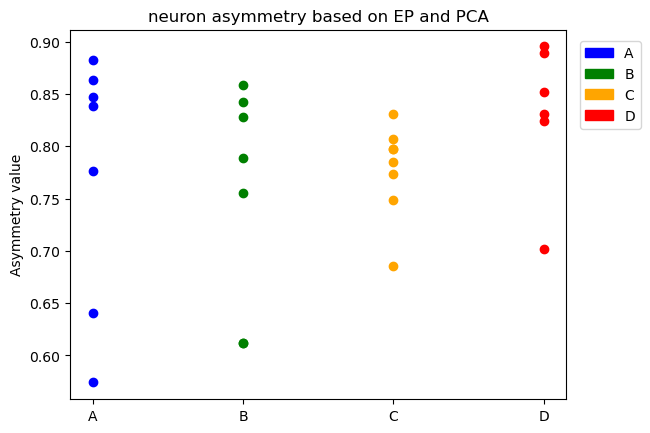

In [14]:
# for scatter plot of Y_value grouped by subtype on the x_axis
fig, ax = plt.subplots(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.PCA_elongation
for i,neu in enumerate(y_vals):
    ax.scatter(x_p[results_df.subtype[i]],neu,c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
x = np.array([1,2,3,4])
my_xticks = ['A','B','C','D']
plt.xticks(x, my_xticks)
plt.ylabel('Asymmetry value')

legend_patches = []
for subtype,color in colors.items():
    legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
            loc=1, borderaxespad=0., prop={'size': 10})
# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)

AttributeError: 'DataFrame' object has no attribute 'cen_EP_yx'

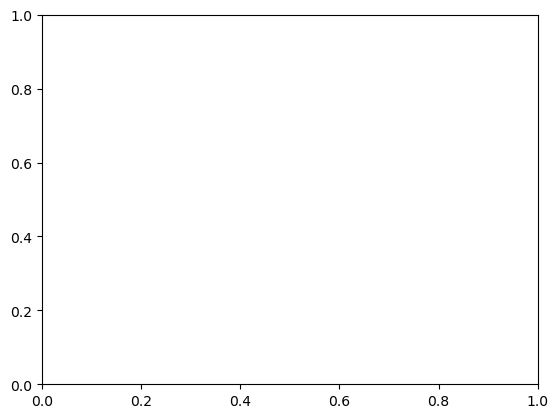

In [15]:
# To plot x,y value of one metric for individual neurons, colored by subtype
fig, ax = plt.subplots(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.cen_EP_yx
for i,neu in enumerate(y_vals):
    ax.plot((0,neu[1]),(0,neu[0]),c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
plt.ylabel('Asymmetry value')
plt.xlabel('Asymmetry value')

legend_patches = []
for subtype,color in colors.items():
    legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
            loc=1, borderaxespad=0., prop={'size': 10})

# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)